# Validation of the compound flood model
## Coastal water levels

The compound flood modelling framework is designed to consider several drivers of flooding: precipitation, upstream river discharges and coastal water levels during a storm. 
The coastal water levels are derived either from a global reanalysis database ([GTSM-ERA5](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=overview)) or using a dedicated local hydrodynamic model (based on Delft3D-FM). The latter option allows us to model storm surges and mean water levels taking into account meteorological conditions and sea level rise in a controlled way, including by varying these components to derive counterfactual scenarios for climate change attribution.

The coastal water levels consist of dynamic components of tide and storm surge, as well as effects of wave setup, and semi-static components of mean sea levels (incl. sea level rise). In order to evaluate the accuracy of the coastal water level data we can compare the model data to observations from tide gauges. This notebook illustrates such a comparison, drawing on functionality of [dfm_tools](https://github.com/Deltares/dfm_tools/blob/main/docs/notebooks/subset_retrieve_sealevel_observations.ipynb).

Please note that the availability of observations varies strongly among different regions. In data-scarce regions, it is possible that no observations are available at the area of interest.

Sources of data for validation:
- UHSLC database (global)
- CMEMS (mainly Europe)
- GESLA-3 (global)
- IOC (global)
- [NOAA Tides & Currents](https://tidesandcurrents.noaa.gov/sea_level_info.html) (specific to the USA)

## Comparison of modelled coastal water levels to data from global tide gauge databases

### Load packages

In [23]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt
from os.path import join
import numpy as np

### Get an overview of global observation stations

To get an overview of the largest publicly available global sealevel observation datasets, we use dfmt.ssh_catalog_subset() with the source argument.  

For IOC we also subset to highlight where they add significantly to the global spatial spatial coverage.

CMEMS database mainly provides tide gauges located in Europe.

GESLA3 database is not used in the analysis, because it cannot be accessed via API at this moment.

In [4]:
#gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems') # mainly Europe
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')

# subsetting gesla
# bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
# bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
# bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
#gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]

>> reading coastlines: 1.35 sec
>> reading country borders: 0.04 sec


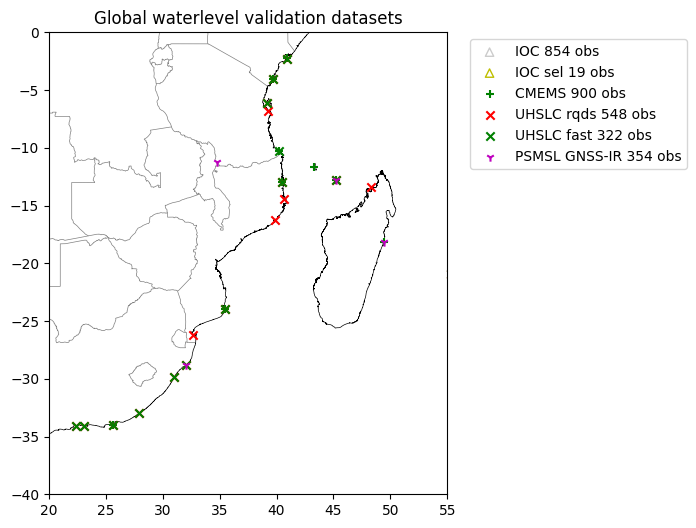

In [5]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
#gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="c", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs", alpha=0.4)
#gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="grey", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs", alpha=0.4)
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="g", label=f"UHSLC fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")


ax.set_ylim(-40,0)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_title("Global waterlevel validation datasets")
ax.set_xlim(20,55)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

We are interested in checking observations within the specific area that we are modelling, and within a specific timeframe. These need to be defined in the following cell:

In [6]:
lon_min, lon_max, lat_min, lat_max = 32.55, 47.22, -27.84, -9.15 # mozambique  

time_min, time_max = '2019-03-01','2019-03-30' #Idai

Next, we will subset all sources in time and space by providing more arguments to dfmt.ssh_catalog_subset. The stations with data in this period and area are plotted.

retrieving psmsl-gnssir time extents for 2 stations: 1 2 
>> reading coastlines: 1.04 sec
>> reading country borders: 0.02 sec


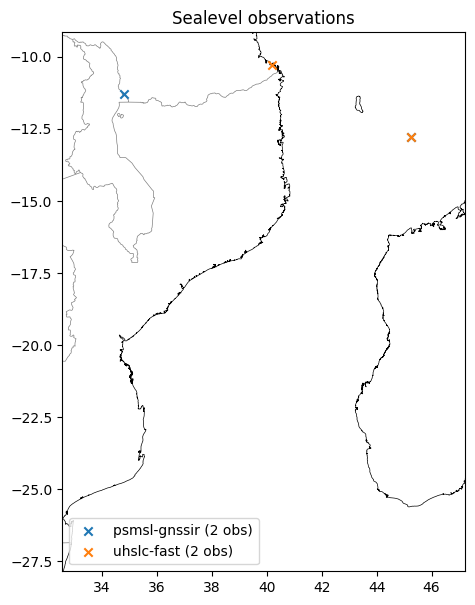

In [9]:
subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
#gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
#cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)
# TODO: no time subsetting supported for rwsddl yet
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
#rwsddl_gpd_sel = dfmt.ssh_catalog_subset(source='rwsddl', **subset_kwargs)
#subset_gpd_list = [gesla_catalog_gpd_sel, ioc_catalog_gpd_sel,
#                  cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
#                  uhslc_json_rqds_sel, uhslc_json_fast_sel,
#                  rwsddl_gpd_sel]
subset_gpd_list = [ioc_catalog_gpd_sel, psmsl_gnssir_gpd_sel,
                  uhslc_json_rqds_sel, uhslc_json_fast_sel] #gesla_catalog_gpd_sel

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

We can retrieve the data for the available points and save it locally in order to inspect it. This data is retrieved with dfmt.ssh_retrieve_data. 

In [10]:
dir_output = "../results/sealevel_data_obs_subset"
os.makedirs(dir_output, exist_ok=True)

We select the sources that have data for our area & time of interest in the list `subset_gpd_list_retrieve`. 

In [11]:
# retrieve data (for all except gesla and ioc)
subset_gpd_list_retrieve = [uhslc_json_fast_sel]
for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)

retrieving data for 2 uhslc-fast stations: 1 2 


Now we can plot the available timeseries from these sources:

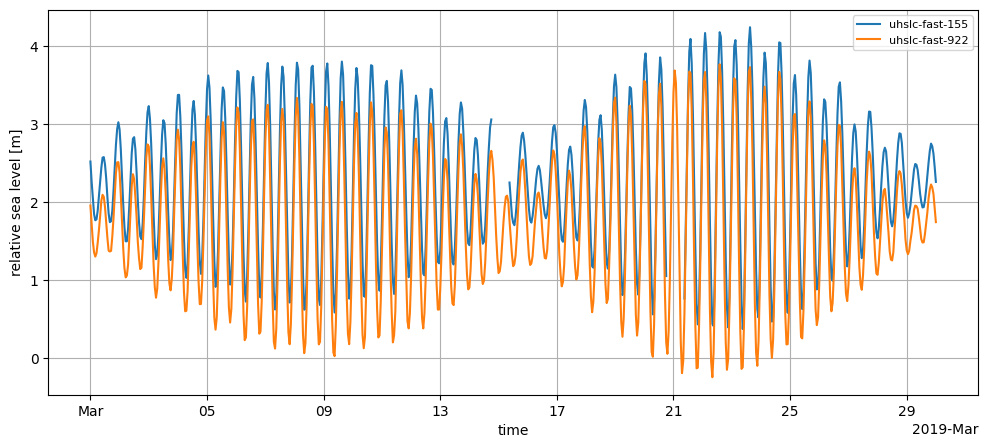

In [14]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
ax.legend(loc=1, fontsize=8)
ax.grid()

### Loading model results

#### From the local Delft3D-FM hydrodynamic model

In [ ]:
dir_model = r'p:\11210471-001-compass\03_Runs\sofala\Idai\dfm\event_450_gebco2024_MZB_GTSMv41_CF0_spw_IBTrACS_CF0'

files_dfm = glob.glob(join(dir_model, r'output\settings_????_map.nc'))
ds_dfm = dfmt.open_partitioned_dataset(files_dfm, remove_edges=False)

>> xu.open_dataset() with 16 partition(s): 1 2 3 

We can check which observation points fall in the domain of the model:

>> reading coastlines: 0.98 sec
>> reading country borders: 0.01 sec


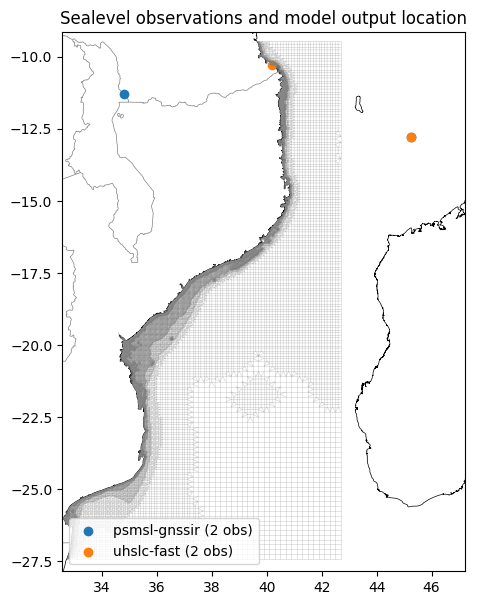

In [57]:
# plot stations
fig,ax = plt.subplots(figsize=(12,7))
ds_dfm.grid.plot(edgecolor='gray', linewidth=0.5, alpha=0.3)

for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="o", label=f"{source} ({nstations} obs)")
#ax.scatter(ds_dfm_sel['mesh2d_face_x'],ds_dfm_sel['mesh2d_face_y'], label='Model output point')

ax.legend(loc=3)
ax.set_title("Sealevel observations and model output location")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

In [58]:
uhslc_json_fast_sel

,name,uhslc_id,ssc_id,gloss_id,country,country_code,fd_span,rq_span,geometry,time_min,time_max,station_name,station_id,station_name_unique,time_ndays,source
uhslc_id,,,,,,,,,,,,,,,,
155,Dzaoudzi,155,dzao,96,France,250,"{'oldest': '1963-10-18', 'latest': '2024-12-02'}","{'oldest': '1963-10-18', 'latest': '2018-12-31'}",POINT (45.257 -12.78),1963-10-18,2024-12-02,Dzaoudzi,155,uhslc-fast-155,22326.0,uhslc-fast
922,Mtwara,922,mtwa,9,"Tanzania, United Republic of",834,"{'oldest': '2018-08-29', 'latest': '2019-03-31'}","{'oldest': None, 'latest': None}",POINT (40.183 -10.283),2018-08-29,2019-03-31,Mtwara,922,uhslc-fast-922,214.0,uhslc-fast


In [59]:
obs_loc = uhslc_json_fast_sel.iloc[1]

In [68]:
ds_dfm = ds_dfm.chunk(chunks={'time':-1, 'mesh2d_nNodes':1000})

In [69]:
# find the index of the grid point nearest to the obs location
lons = obs_loc.geometry.x
lats = obs_loc.geometry.y
dists = (lats - ds_dfm['mesh2d_face_y'].values)**2 + (lons - ds_dfm['mesh2d_face_x'].values)**2
closest_idx = np.argmin(dists)

#subset model data to the location
ds_dfm_sel = ds_dfm.isel(mesh2d_nFaces=closest_idx)

In [70]:
ds_obs = xr.open_dataset(join(dir_output, f'{obs_loc['station_name_unique']}.nc'))

In [74]:
ds_dfm_sel['mesh2d_s1'].load()

RuntimeError: Invalid argument

In [ ]:
# plot the GTSM-ERA5 timeseries together with the observational timeseries
fig,ax = plt.subplots(figsize=(12,5))

ds_obs.waterlevel.plot(ax=ax, label=obs_loc['station_name_unique'])

ds_dfm_sel['mesh2d_s1'].plot(ax=ax, label='DFM model output')

ax.legend(loc=1, fontsize=8)
ax.grid()

#### From GTSM-ERA5 global dataset

In [50]:
dir_gtsm = r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\waterlevel'

In [ ]:
files_gtsm = glob.glob(join(dir_gtsm, f'reanalysis_waterlevel_hourly_{time_min[:3]}_*_v3.nc'))

In [ ]:
ds_gtsm = xr.open_mfdataset(files_gtsm)
ds_gtsm = ds_gtsm.sel(time=slice(time_min, time_max))

In [ ]:
# find the index of the grid point nearest to the obs location
lons = obs_loc.geometry.x
lats = obs_loc.geometry.y
dists = (lats - ds_gtsm['station_y_coordinate'].values)**2 + (lons - ds_gtsm['station_x_coordinate'].values)**2
closest_idx = np.argmin(dists)

#subset model data to the location
station = ds_gtsm.stations.values[closest_idx]

ds_gtsm_sel = ds_gtsm.sel(stations=station)

In [ ]:
# plot stations
fig,ax = plt.subplots(figsize=(12,7))

for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    subset_gpd.geometry.plot(ax=ax, marker="o", label=f"{source} ({nstations} obs)")
#ax.scatter(ds_dfm_sel['mesh2d_face_x'],ds_dfm_sel['mesh2d_face_y'], label='Model output point')

obs_loc.geometry.plot(ax=ax, marker='x', label='GTSM-ERA5')

ax.legend(loc=3)
ax.set_title("Sealevel observations and model output location")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

In [ ]:
# plot the GTSM-ERA5 timeseries together with the observational timeseries
fig,ax = plt.subplots(figsize=(12,5))

ds_obs.waterlevel.plot(ax=ax, label=obs_loc['station_name_unique'])

ds_gtsm_sel.waterlevel.plot(ax=ax, label='GTSM-ERA5')

ax.legend(loc=1, fontsize=8)
ax.grid()